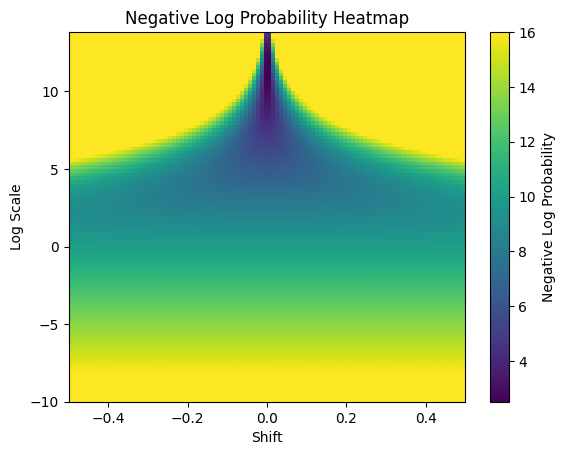

In [135]:
import os
import sys

if os.path.basename(os.getcwd()) == "testing":
    os.chdir(os.path.dirname(os.getcwd()))
    sys.path.append(os.getcwd())

from lossless.util.distribution import (
    discretized_logistic_logp,
    get_mu_and_scale_linear_color,
)
import lossless.util.color_transform as color_transform
import torch
import matplotlib.pyplot as plt
import numpy as np
from lossless.util.color_transform import ColorBitdepths
from lossless.component.types import POSSIBLE_ENCODING_DISTRIBUTIONS
import constriction
import struct


class StopExecution(Exception):
    def _render_traceback_(self):
        return []


def unget_scale(scale: torch.Tensor) -> torch.Tensor:
    """Helper function to get log_scale from scale

    Args:
        - scale (torch.Tensor): Tensor of shape N x C x H x W
    """
    logscale = torch.log(scale) * -2
    logscale = torch.clamp(logscale, min=-10.0, max=13.8155)
    return logscale


class MonochromeBitdepths(color_transform.ColorBitdepths):
    def __init__(self) -> None:
        self.bitdepths = [8]
        self.scaling_factors = [255]
        self.bins = [256]
        self.ranges_int = [[0, 255]]


DEFAULT_LOGSCALE = 13.4
DEFAULT_SHIFT = 0.0
DEFAULT_IMG_VALUE = 0.00802


def plot_logp(shifts: np.ndarray | None, logscales: np.ndarray | None):
    channel_ranges = MonochromeBitdepths()
    x = torch.ones((1, 1, 1, 1)) * DEFAULT_IMG_VALUE

    # shifts is a linspace
    logps = []

    if shifts is not None:
        for shift_value in shifts:
            shift = torch.tensor(shift_value)
            mu = x + shift
            log_scale = torch.clamp(
                torch.tensor(DEFAULT_LOGSCALE), min=-10.0, max=13.8155
            )
            scale = torch.exp(-0.5 * log_scale)
            logp = discretized_logistic_logp(mu, scale, x, channel_ranges)
            logps.append(-logp.item())
        plt.plot(shifts, logps)
        plt.xlabel("Shift")
        plt.ylabel("Negative Log Probability")
        plt.title("Negative Log Probability vs Shift")
        plt.show()
    if logscales is not None:
        logps = []
        for logscale_value in logscales:
            shift = torch.tensor(DEFAULT_SHIFT)
            mu = x + shift
            log_scale = torch.clamp(
                torch.tensor(logscale_value), min=-10.0, max=13.8155
            )
            scale = torch.exp(-0.5 * log_scale)
            logp = discretized_logistic_logp(mu, scale, x, channel_ranges)
            logps.append(-logp.item())
        plt.plot(logscales, logps)
        plt.xlabel("Log Scale")
        plt.ylabel("Negative Log Probability")
        plt.title("Negative Log Probability vs Log Scale")
        plt.show()


def logp_image(shifts: np.ndarray, logscales: np.ndarray):
    channel_ranges = MonochromeBitdepths()
    x = torch.ones((1, 1, 1, 1)) * DEFAULT_IMG_VALUE

    logp_matrix = np.zeros((len(logscales), len(shifts)))

    for j, shift_value in enumerate(shifts):
        for i, logscale_value in enumerate(logscales):
            shift = torch.tensor(shift_value)
            mu = x + shift
            log_scale = torch.clamp(
                torch.tensor(logscale_value), min=-10.0, max=13.8155
            )
            scale = torch.exp(-0.5 * log_scale)
            logp = discretized_logistic_logp(mu, scale, x, channel_ranges)
            logp_matrix[i, j] = -logp.item()

    plt.imshow(
        logp_matrix,
        extent=(shifts[0], shifts[-1], logscales[0], logscales[-1]),
        aspect="auto",
        origin="lower",
    )
    plt.colorbar(label="Negative Log Probability")
    plt.xlabel("Shift")
    plt.ylabel("Log Scale")
    plt.title("Negative Log Probability Heatmap")
    plt.show()


logp_image(np.linspace(-0.5, 0.5, 100), np.linspace(-10.0, 13.8154, 100))

tensor(2.0862e-07) tensor(0.0338) tensor(0.6449)


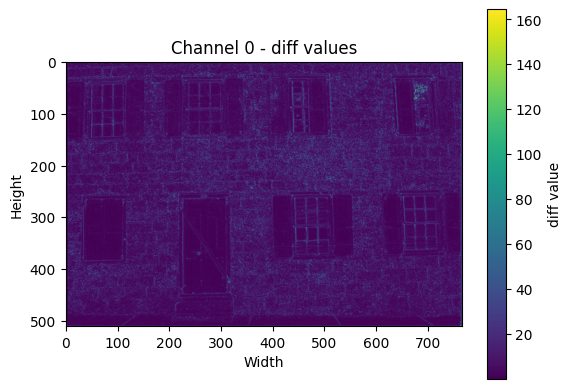

tensor(0.) tensor(0.0008) tensor(0.0679)


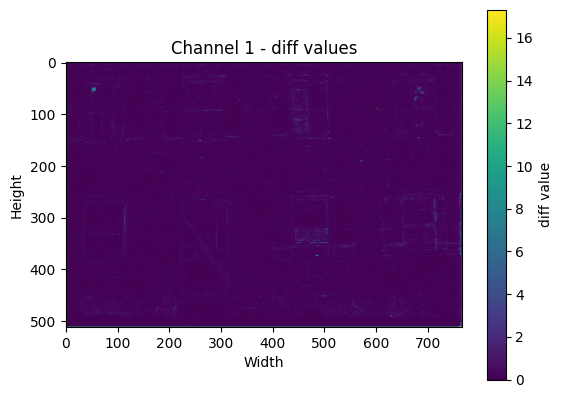

tensor(2.2352e-08) tensor(0.0037) tensor(0.1099)


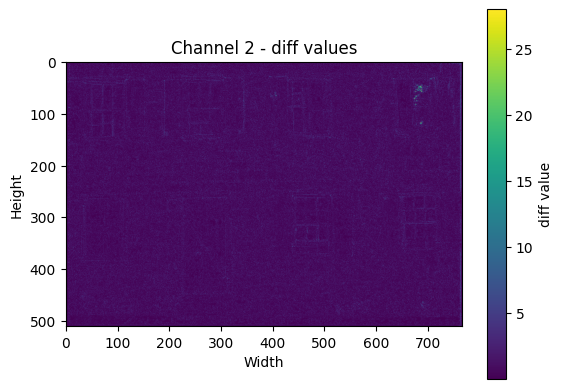

In [142]:
# ==========================================================================================
# Load raw_out and image from Cool-Chic training
# ==========================================================================================
raw_out = torch.tensor(np.load("./testing/data/encoded_raw_out.npy"))
image = torch.tensor(np.load("./testing/data/original_image.npy"))

mu, scale = get_mu_and_scale_linear_color(
    raw_out, image
)

# ==========================================================================================
# Visualize diff = abs(mu - image)
# ==========================================================================================
for channel in range(3):
    channel_ranges = MonochromeBitdepths()
    mu_slice = mu[:, channel : channel + 1]
    image_slice = image[:, channel : channel + 1]
    diff = abs(mu_slice - image_slice)
    print(diff.min(), diff.mean(), diff.max())
    plt.figure()
    plt.title(f"Channel {channel} - diff values")
    plt.imshow(diff[0].permute(1, 2, 0).numpy()*255)
    plt.colorbar(label="diff value")
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.show()

In [137]:
def get_bits_per_pixel(w, h, c, encoded_bytes):
    num_pixels = w * h * c
    num_bits = 0
    for bytes_channel in encoded_bytes:
        num_bits += len(bytes_channel) * 8
    return num_bits / num_pixels


def _laplace_cdf(
    x: torch.Tensor, expectation: torch.Tensor, scale: torch.Tensor
) -> torch.Tensor:
    """Compute the laplace cumulative evaluated in x. All parameters
    must have the same dimension.
    Re-implemented here coz it is faster than calling the Laplace distribution
    from torch.distributions.

    Args:
        x (Tensor): Where the cumulative if evaluated.
        expectation (Tensor): Expectation.
        scale (Tensor): Scale

    Returns:
        Tensor: CDF(x, mu, scale)
    """
    shifted_x = x - expectation
    return 0.5 - 0.5 * (shifted_x).sign() * torch.expm1(
        -(shifted_x).abs() / scale
    )


def _logistic_cdf(
    x: torch.Tensor, mu: torch.Tensor, s: torch.Tensor
) -> torch.Tensor:
    """Compute the logistic cumulative evaluated in x. All parameters
    must have the same dimension.
    Re-implemented here coz it is faster than calling the Logistic distribution
    from torch.distributions.

    Args:
        x (Tensor): Where the cumulative if evaluated.
        mu (Tensor): Expectation.
        s (Tensor): Scale

    Returns:
        Tensor: CDF(x, mu, scale)
    """
    z = (x - mu) / s
    return torch.sigmoid(z)


def calculate_probability_distribution(
    mu,
    s,
    color_bitdepths: ColorBitdepths,
    distribution: POSSIBLE_ENCODING_DISTRIBUTIONS,
    channel_idx: int,
):
    """Calculate Logistic probability distribution for arithmetic coding.
    Works for any shape of mu and s, adds one dimension at the end for the probability axis.
    """
    # Create the base tensor of quantized values
    new_tensor = torch.linspace(
        0.0,
        (
            color_bitdepths.ranges_int[channel_idx][1]
            - color_bitdepths.ranges_int[channel_idx][0]
        )
        / color_bitdepths.scaling_factors[channel_idx],
        steps=color_bitdepths.bins[channel_idx],
        device=mu.device,
    )
    new_shape = (
        *mu.shape,
        color_bitdepths.bins[channel_idx],
    )  # add one dimension at the end
    new_tensor = new_tensor.view(
        *([1] * mu.ndim), color_bitdepths.bins[channel_idx]
    ).expand(*new_shape)

    # Compute boundaries for each bin
    x_minus = new_tensor - 0.5 / color_bitdepths.bins[channel_idx]
    x_plus = new_tensor + 0.5 / color_bitdepths.bins[channel_idx]

    # Expand mu and s with one trailing dimension
    mu_expanded = mu.unsqueeze(-1)
    s_expanded = s.unsqueeze(-1)

    # Logistic CDF difference between bin edges (use the logistic cdf function)
    if distribution == "laplace":
        cdf_minus = _laplace_cdf(x_minus, mu_expanded, s_expanded)
        cdf_plus = _laplace_cdf(x_plus, mu_expanded, s_expanded)
    else:
        cdf_minus = _logistic_cdf(x_minus, mu_expanded, s_expanded)
        cdf_plus = _logistic_cdf(x_plus, mu_expanded, s_expanded)
    prob_t = cdf_plus - cdf_minus
    if distribution == "dummy":
        prob_t = torch.ones_like(cdf_plus)
    prob_t = torch.clamp_min(prob_t, 2 ** (-16))
    prob_t = prob_t / prob_t.sum(dim=-1, keepdim=True)

    assert torch.all(
        torch.isclose(prob_t.sum(dim=-1), torch.ones_like(mu))
    ), "Probabilities do not sum to 1"
    assert torch.all(prob_t.min() > 0), "Some probabilities are zero"
    return prob_t

In [138]:
def encode(
    x: torch.Tensor,
    mu: torch.Tensor,
    scale: torch.Tensor,
    ct: color_transform.ColorBitdepths = color_transform.YCoCgBitdepths(),
    distribution: POSSIBLE_ENCODING_DISTRIBUTIONS = "logistic",
    output_path="./test-workdir/encoder_size_test/coolchic_encoded.binary",
):
    x = x * 255.0
    x_reshape = x.to(torch.int16).cpu()

    B, C, H, W = x.shape
    enc = constriction.stream.stack.AnsCoder()  # type: ignore
    bits_theoretical = 0

    with torch.no_grad():
        scale_theoretical_bits = 0
        mu = mu.flatten(2, 3).permute(0, 2, 1)  # B, H*W, C
        scale = scale.flatten(2, 3).permute(0, 2, 1)  # B, H*W, C

        probs_logistic = [
            calculate_probability_distribution(
                mu - ct.ranges_int[ch_ind][0] / ct.scaling_factors[ch_ind],
                scale,
                color_bitdepths=ct,
                distribution=distribution,
                channel_idx=ch_ind,
            )
            for ch_ind in range(C)
        ]

        scale_theoretical_bits = 0
        for wh in range(x.shape[2] * x.shape[3]):
            for c in range(x.shape[1]):
                sym: int = (
                    x_reshape.flatten(2, 3).permute(0, 2, 1)[0, -wh - 1, -c - 1]
                ).int().item() - ct.ranges_int[-c - 1][0]
                prob_t = probs_logistic[-c - 1][0, -wh - 1, -c - 1]
                scale_theoretical_bits += -torch.log2(prob_t[sym]).item()
                model = constriction.stream.model.Categorical(  # type: ignore
                    prob_t.detach().cpu().numpy(), perfect=False
                )
                try:
                    enc.encode_reverse(sym, model)
                except Exception as e:

                    print(f"Error encoding symbol {sym} for channel {c}: {e}")
                    raise e
        bits_theoretical += scale_theoretical_bits

    bitstream = enc.get_compressed()
    bitstream.tofile(output_path)
    with open(output_path, "rb") as f:
        original_data = f.read()
    with open(output_path, "wb") as f:
        # Pack two 32-bit integers into binary
        f.write(struct.pack("iii", H, W, C))
        f.write(original_data)

    print(f"Theoretical bits per sub pixel: {bits_theoretical/float(W*H*C)}")
    return probs_logistic


def decode(
    bitstream_path,
    mu: torch.Tensor,
    scale: torch.Tensor,
    ct=color_transform.ColorBitdepths(),
    distribution: POSSIBLE_ENCODING_DISTRIBUTIONS = "logistic",
):
    with open(bitstream_path, "rb") as f:
        header = f.read(12)  # 3 integers * 4 bytes each
        H, W, C = struct.unpack("iii", header)
    bitstream = np.fromfile(bitstream_path, dtype=np.uint32, offset=12)
    dec = constriction.stream.stack.AnsCoder(bitstream)  # type: ignore

    x = -torch.ones(1, C, H, W)
    with torch.no_grad():
        mu = mu.flatten(2, 3).permute(0, 2, 1)  # B, H*W, C
        scale = scale.flatten(2, 3).permute(0, 2, 1)  # B, H*W, C

        probs_logistic = [
            calculate_probability_distribution(
                mu - ct.ranges_int[ch_ind][0] / ct.scaling_factors[ch_ind],
                scale,
                color_bitdepths=ct,
                distribution=distribution,
                channel_idx=ch_ind,
            )
            for ch_ind in range(C)
        ]
        for h in range(H):
            for w in range(W):
                for c in range(C):
                    prob = probs_logistic[c][0, h * W + w, c]
                    prob_array = prob.detach().cpu().flatten().numpy()
                    model = constriction.stream.model.Categorical(  # type: ignore
                        prob_array, perfect=False
                    )
                    decoded_char = (
                        torch.tensor(dec.decode(model, 1)[0]).float()
                        + ct.ranges_int[c][0]
                    )
                    x[0, c, h, w] = decoded_char

    x = x.cpu() / 255

    return x, probs_logistic

## TESTING ENCODE DECODE LOSSLESSNESS

### Cool-Chic Predicted Parameters

Theoretical bits per sub pixel: 2.4904356003756525


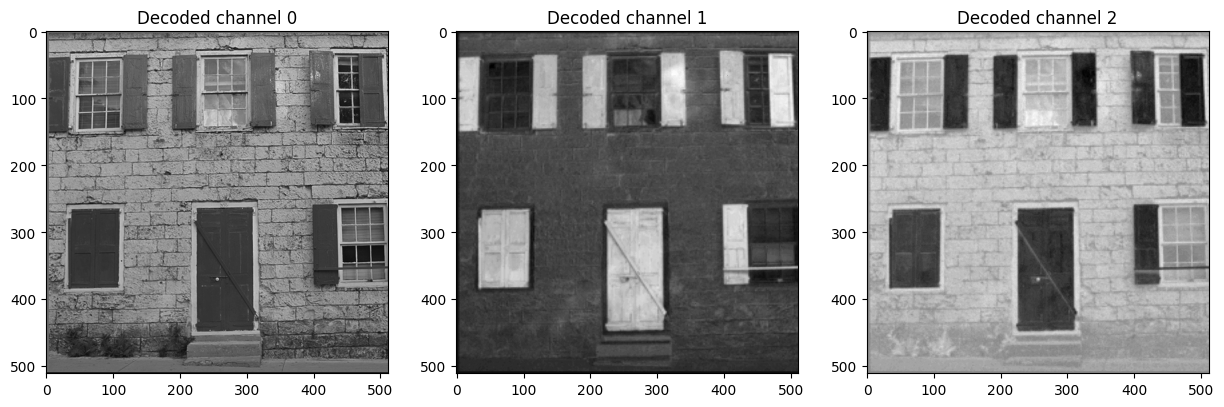

In [139]:
mu, scale = get_mu_and_scale_linear_color(raw_out, image)

offset = 0
patch_size = 512
patch_image = image[
    :, :, offset : offset + patch_size, offset : offset + patch_size
]
patch_mu = mu[:, :, offset : offset + patch_size, offset : offset + patch_size]
patch_scale = scale[
    :, :, offset : offset + patch_size, offset : offset + patch_size
]

probs_enc = encode(
    patch_image,
    patch_mu,
    patch_scale,
    ct=color_transform.YCoCgBitdepths(),
    distribution="logistic",
    output_path="./test-workdir/encoder_size_test/coolchic_encoded_dummy.binary",
)
dec, probs_dec = decode(
    "./test-workdir/encoder_size_test/coolchic_encoded_dummy.binary",
    patch_mu,
    patch_scale,
    ct=color_transform.YCoCgBitdepths(),
    distribution="logistic",
)

assert torch.allclose(
    patch_image.cpu(), dec.cpu()
), "Decoded image does not match original!"


# rewrite the figure above to subplots with 3 columns and 1 row
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for C in range(3):
    axs[C].imshow(dec[0, C, :, :], cmap="gray")
    axs[C].set_title(f"Decoded channel {C}")
plt.show()

### Random Image Patch

Theoretical bits per sub pixel: 9.401039580038438


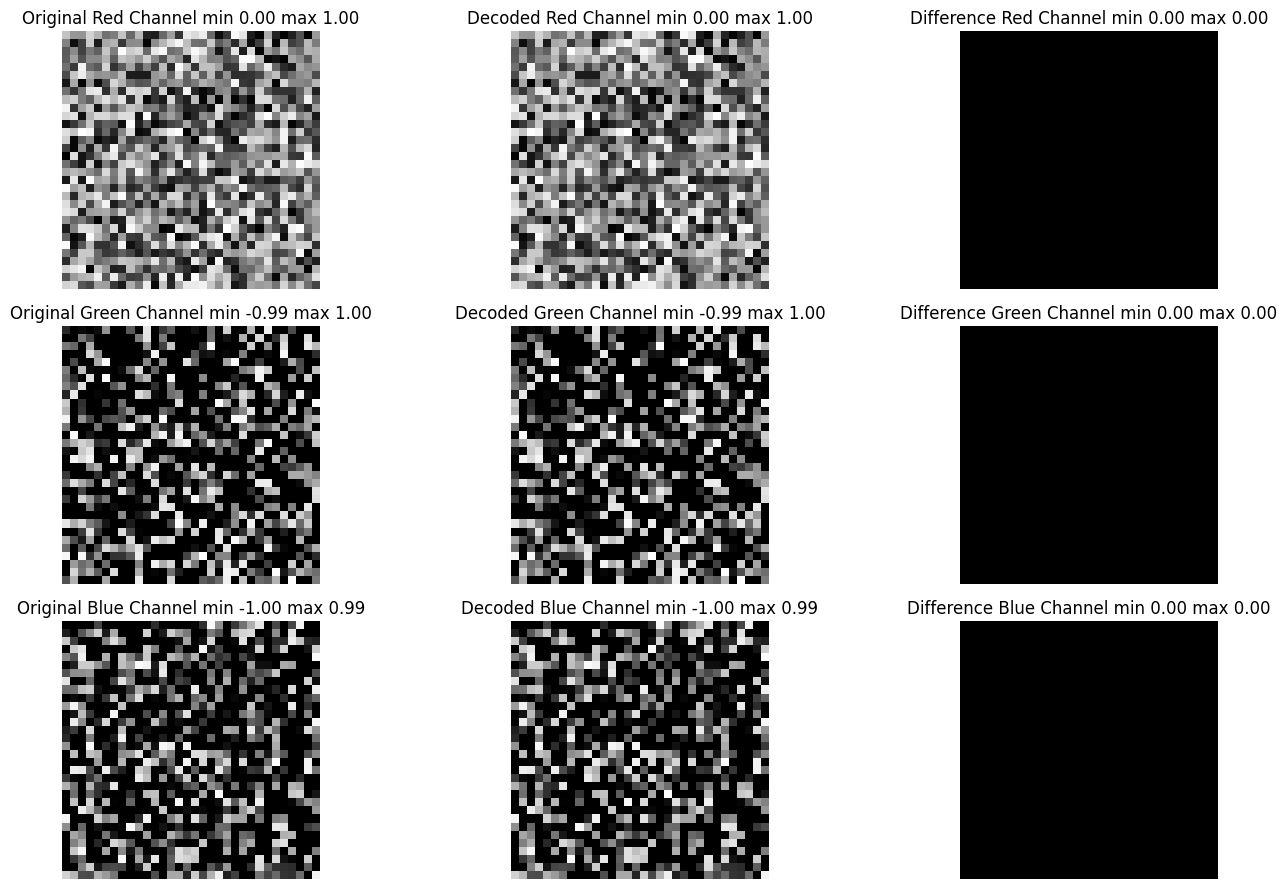

Max difference between original and decoded image: 0.0
Encode-decode losslessness test passed!


In [140]:
# image = torch.ones((1, 3, 32, 32)) * 0.5
# image[:, 0, :16, :16] = 0.1
# image[:, 1, :16, 16:] = 0.3
# image[:, 2, 16:, :16] = 0.9
image = torch.rand((1, 3, 32, 32))
image[0, 1:] = image[0, 1:] * 2 - 1
image = torch.round(image * 255) / 255

mu = torch.rand_like(image)
scale = torch.rand_like(image)

col_b = color_transform.YCoCgBitdepths()
probs_enc = encode(image, mu, scale, ct=col_b, distribution="logistic")
decoded_image, probs_dec = decode("./test-workdir/encoder_size_test/coolchic_encoded.binary", mu, scale, ct=col_b, distribution="logistic")

assert torch.allclose(probs_enc[0], probs_dec[0]), "Probability distributions for channel 0 do not match after encoding and decoding"

# show the original and decoded images side by side. Show the channels separately in a 3 rows and 3 columns layout
fig, axs = plt.subplots(3, 3, figsize=(15, 9))
diff = torch.abs(image - decoded_image)
channel_names = ['Red', 'Green', 'Blue']
for i in range(3):
    axs[i, 0].imshow(image[0, i].cpu(), cmap='gray', vmin=0, vmax=1)
    axs[i, 0].set_title(f'Original {channel_names[i]} Channel min {image[0, i].min().item():.2f} max {image[0, i].max().item():.2f}')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(decoded_image[0, i].cpu(), cmap='gray', vmin=0, vmax=1)
    axs[i, 1].set_title(f'Decoded {channel_names[i]} Channel min {decoded_image[0, i].min().item():.2f} max {decoded_image[0, i].max().item():.2f}')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(diff[0, i].cpu(), cmap='gray', vmin=0, vmax=1)
    axs[i, 2].set_title(f'Difference {channel_names[i]} Channel min {diff[0, i].min().item():.2f} max {diff[0, i].max().item():.2f}')
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()


print(f"Max difference between original and decoded image: {diff.max().item()}")
# show diff channel by channel
assert torch.allclose(image, decoded_image, atol=1e-6)
print("Encode-decode losslessness test passed!")